# CIS053 Final Project - ML Titanic
Anne-Elise Chung  
Hermanda Mak

## Executive Summary

todo -after everything else

## Background

The purpose of this project is to build a predictive model that can classify the sort of passenger on Titatic that will most likely survive after the shipwreck. Moreover, we aim to discover the most influential features that affect the possibility of survival among the Titanic passengers.

The sinking of the Titanic happened on April 15, 1912, where the resulting death of 1502 out of 2224 passengers led to global attention regarding safety of sea traveling and way to avoid another shipwreck of such sort. The major reason behind the disastrous outcome is the lack of lifeboats. Based on the collected data of survival history on the Titanic, we can understand and build a predictive model that would identify which type of passenger could survive on such shipwreck.

## Survey of Existing Work

https://www.kaggle.com/code/abdmental01/exploring-data-visual-insights-unveiled#About-Function
- Author: MUHAMMAD ABDULLAH
- Techniques Used: this submission was purely showing some data visualization techniques, but it serves as a helpful comparison for the upcoming EDA work in this report.
- Results:
- ![results from data vis insights](exploring_data_vis_insights_revealed.png)

https://www.kaggle.com/code/gusthema/titanic-competition-w-tensorflow-decision-forests
- Author: GUSTHEMA
- Techniques Used: TensorFlow Decision Trees
- Results: 
- Notes: This Kaggle submission received 675 upvotes, compared to many of the other submissions that only received 2 or 3 upvotes. The popularity of this post might indicate that the results and techniques are probably sound and would be good for comparison.


https://www.kaggle.com/code/eneskosar19/titanic-sample-submission-random-forest
- Author:
- Techniques Used:
- Results:


https://www.kaggle.com/code/whitedevil4648/neural-networks-titanic
- Author: WHITEDEVIL4648
- Techniques Used: neural networks
- Results:
- Notes: 


## Our Approach


- EDA analysis
- Eliminate unuseful features and data entry
- Create classification models: logistic regression, ensemble trees (random forest, bagging , ADA boost), k-means clustering, decision tree classifier, SVM, neural network
- Standardize and Normalize to see if a more reliable model could be built
- Use cross validation to verify the accuracy of the models so to identify the best predictive model 

## Code and Results


In [548]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from numpy import set_printoptions
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [549]:
test_data = read_csv('./test.csv')
train_data = read_csv('./train.csv')

train_data.dropna(inplace=True)
train_data.reset_index(drop=True, inplace=True)

In [550]:
# x = data without output and unique identifiers
x = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
y = train_data['Survived']
x_names = x.columns

# x_clean = input that are not categorical
x_clean = x.drop(['Cabin', 'Sex', 'Embarked', 'Pclass'], axis=1)
x_clean_names = x_clean.columns

# replace NaN with 'Unknown'
x_num = x
x_num['Cabin'] = x_num['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'Unknown')

# convert categorical value to numerical value using LabelEncoder
le_cabin = LabelEncoder()
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
x_num['Cabin'] = le_cabin.fit_transform(x_num['Cabin'])
x_num['Sex'] = le_sex.fit_transform(x_num['Sex'].fillna('Unknown'))
x_num['Embarked'] = le_embarked.fit_transform(x_num['Embarked'].fillna('Unknown'))

# x_category = dataframe for categorical features 
x_category = pd.concat([x_num['Cabin'], x_num['Sex'], x_num['Embarked'], x_num['Pclass']], axis=1)
x_category


,Cabin,Sex,Embarked,Pclass
0,2,0,0,1
1,2,0,2,1
2,4,1,2,1
3,6,0,2,3
4,2,0,2,1
...,...,...,...,...
178,3,0,2,1
179,1,1,2,1
180,2,0,0,1
181,1,0,2,1


In [551]:

# Mapping of category value with numerical value

sex_mapping = le_sex.classes_
embarked_mapping = le_embarked.classes_
cabin_mapping = le_cabin.classes_

mappings_df = pd.DataFrame({
    'Sex': pd.Series(sex_mapping),
    'Embarked': pd.Series(embarked_mapping),
    'Cabin': pd.Series(cabin_mapping)
})

mappings_df = mappings_df.fillna("")

print("Mapping of Categorical Value with Numerical Value")
mappings_df


Mapping of Categorical Value with Numerical Value


,Sex,Embarked,Cabin
0,female,C,A
1,male,Q,B
2,,S,C
3,,,D
4,,,E
5,,,F
6,,,G
7,,,T


In [552]:
X_arr = x_num.values
Y_arr = y.values

# create train_data with numerical value of categories
train_data_num = pd.concat([y, x_num], axis=1)

# train_data_eda = dataset without categorical data
train_data_eda = train_data.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass'], axis =1)

## EDA with Regular Data

In [553]:
## descriptive stats
set_option('display.width', 100)
set_option('display.precision', 2)
description = train_data_eda.describe()
description

,Survived,Age,SibSp,Parch,Fare
count,183.00,183.00,183.00,183.00,183.00
mean,0.67,35.67,0.46,0.48,78.68
std,0.47,15.64,0.64,0.75,76.35
min,0.00,0.92,0.00,0.00,0.00
25%,0.00,24.00,0.00,0.00,29.70
50%,1.00,36.00,0.00,0.00,57.00
75%,1.00,47.50,1.00,1.00,90.00
max,1.00,80.00,3.00,4.00,512.33


## Notes on Descriptive Statistics
-todo

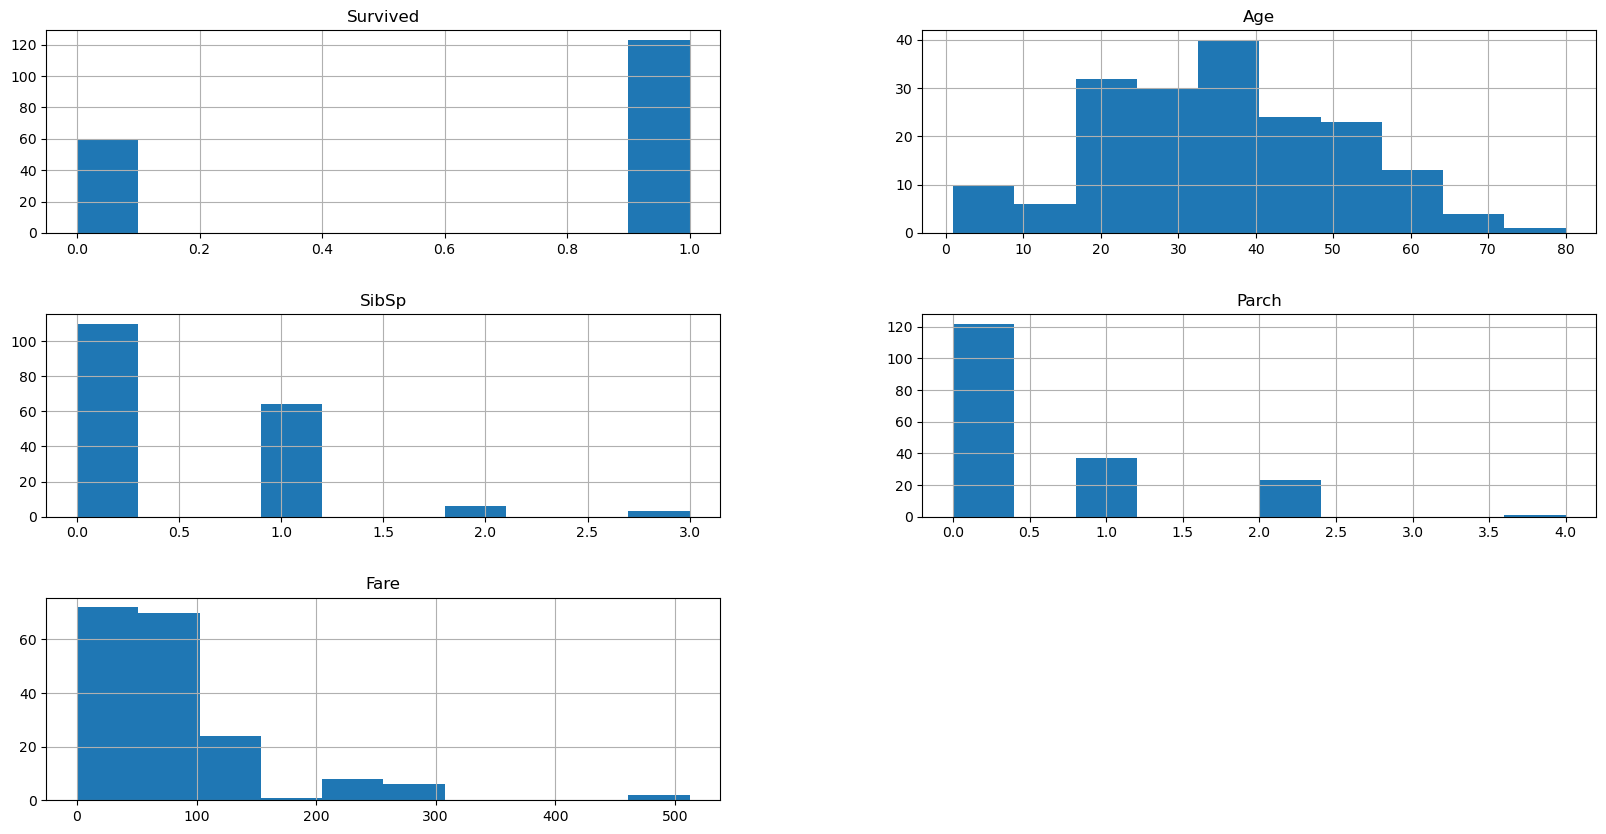

In [554]:
## histograms
train_data_eda.hist(figsize = (20, 10))
plt.margins(2,2)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

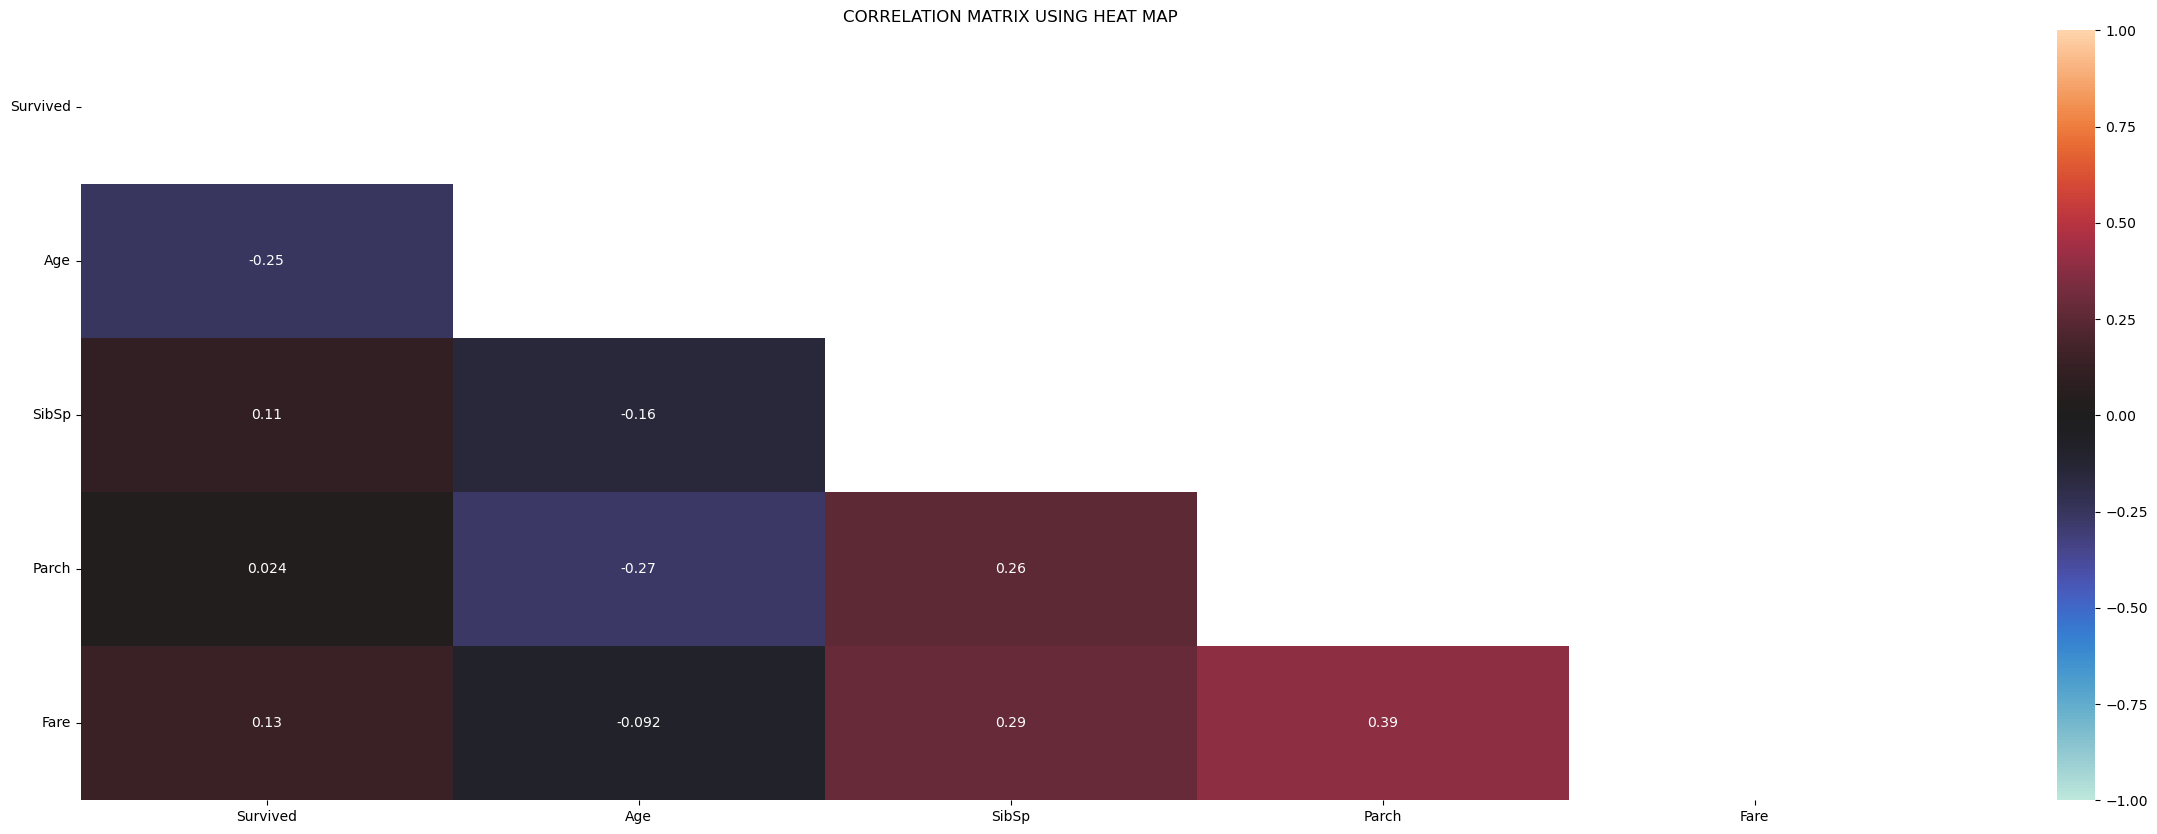

In [555]:
## correlation heatmap   
import seaborn as sns
import numpy as np

plt.figure(figsize=(30,10))
corMat = train_data_eda.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

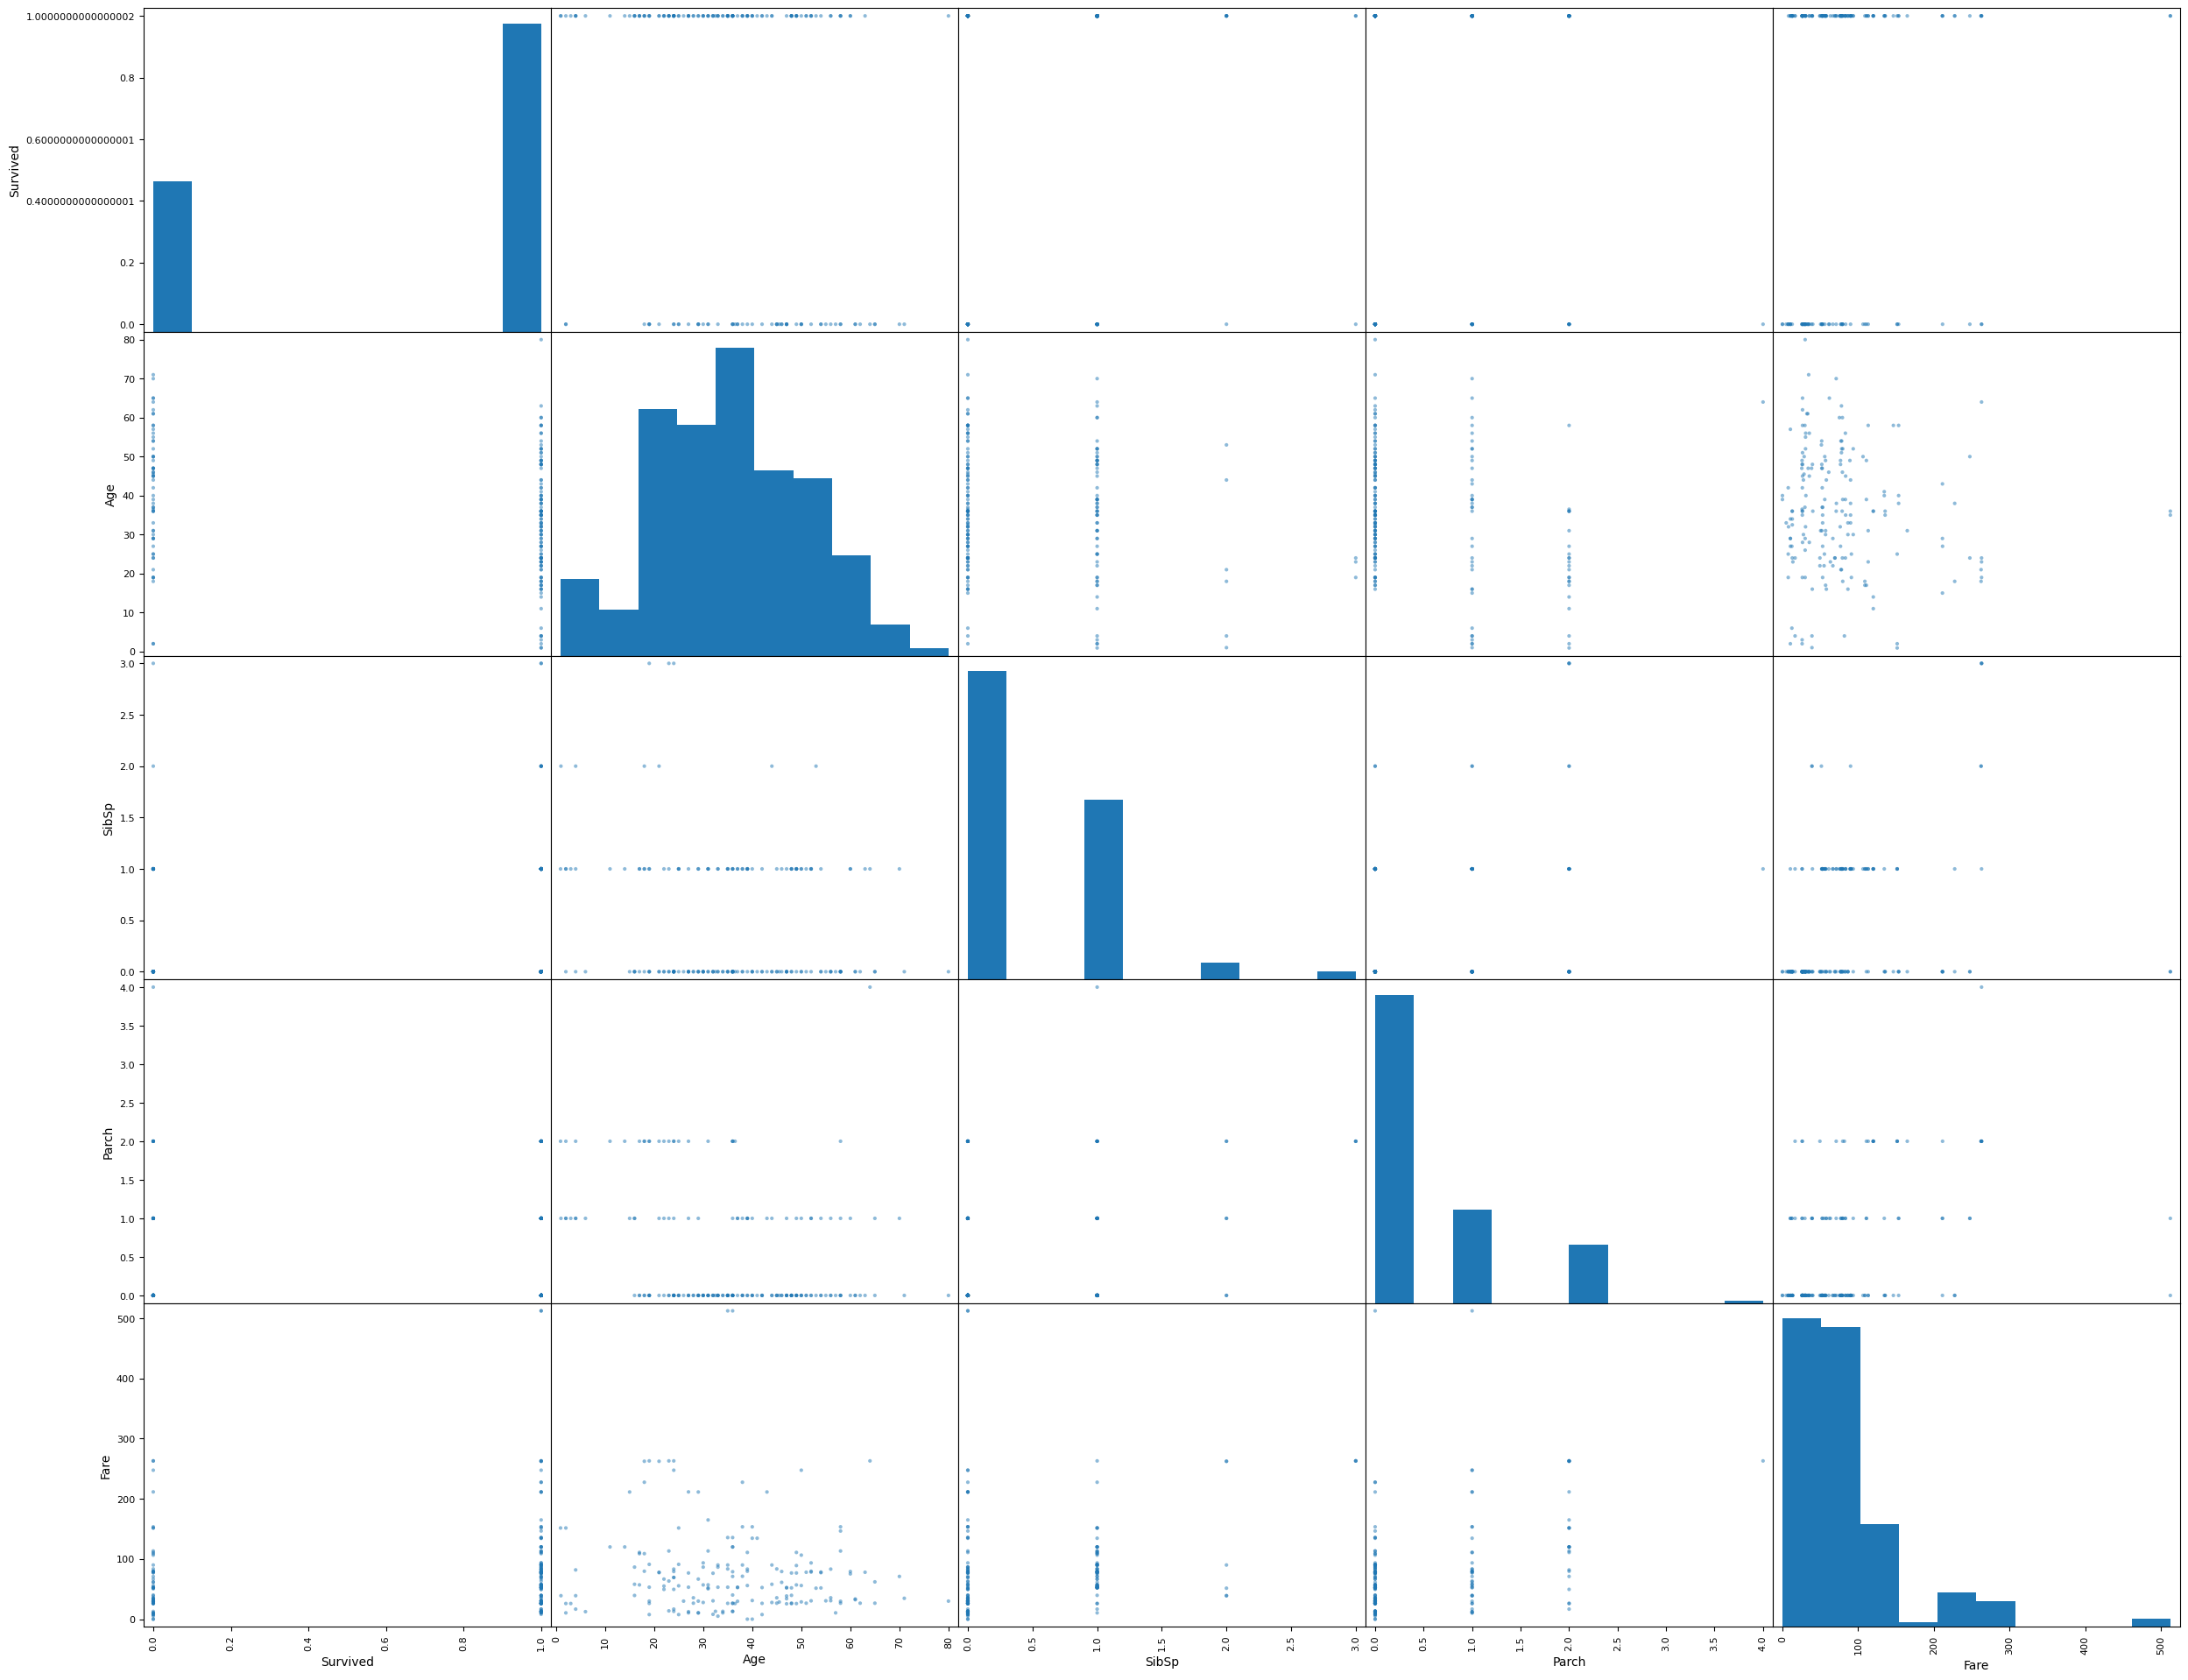

In [556]:
## scatterplots
from pandas.plotting import scatter_matrix

scatter_matrix(train_data_eda, figsize = (30,24))
plt.show()

## Notes on Scatterplots
-todo

## EDA with Standardized Data

In [557]:
data_stan = pd.DataFrame(StandardScaler().fit_transform(x_clean), columns=x_clean_names)
x_stan = pd.concat([data_stan, x_category], axis=1)
x_stan


,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked,Pclass
0,0.15,0.83,-0.63,-0.10,2,0,0,1
1,-0.04,0.83,-0.63,-0.34,2,0,2,1
2,1.17,-0.72,-0.63,-0.35,4,1,2,1
3,-2.03,0.83,0.70,-0.81,6,0,2,3
4,1.43,-0.72,-0.63,-0.68,2,0,2,1
...,...,...,...,...,...,...,...,...
178,0.73,0.83,0.70,-0.34,3,0,2,1
179,-0.17,-0.72,-0.63,-0.97,1,1,2,1
180,1.30,-0.72,0.70,0.06,2,0,0,1
181,-1.07,-0.72,-0.63,-0.64,1,0,2,1


In [558]:
data_stan = pd.concat([y, data_stan], axis=1)
data_stan


,Survived,Age,SibSp,Parch,Fare
0,1,0.15,0.83,-0.63,-0.10
1,1,-0.04,0.83,-0.63,-0.34
2,0,1.17,-0.72,-0.63,-0.35
3,1,-2.03,0.83,0.70,-0.81
4,1,1.43,-0.72,-0.63,-0.68
...,...,...,...,...,...
178,1,0.73,0.83,0.70,-0.34
179,0,-0.17,-0.72,-0.63,-0.97
180,1,1.30,-0.72,0.70,0.06
181,1,-1.07,-0.72,-0.63,-0.64


In [559]:
X_arr = x_num.values
Y_arr = y.values

data_stan.describe()

,Survived,Age,SibSp,Parch,Fare
count,183.00,1.83e+02,1.83e+02,1.83e+02,1.83e+02
mean,0.67,-1.65e-16,-1.46e-17,3.88e-17,1.14e-16
std,0.47,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,0.00,-2.23e+00,-7.23e-01,-6.32e-01,-1.03e+00
25%,0.00,-7.48e-01,-7.23e-01,-6.32e-01,-6.43e-01
50%,1.00,2.09e-02,-7.23e-01,-6.32e-01,-2.85e-01
75%,1.00,7.58e-01,8.34e-01,6.97e-01,1.49e-01
max,1.00,2.84e+00,3.95e+00,4.68e+00,5.70e+00


## Notes on Descriptive Statistics
-todo

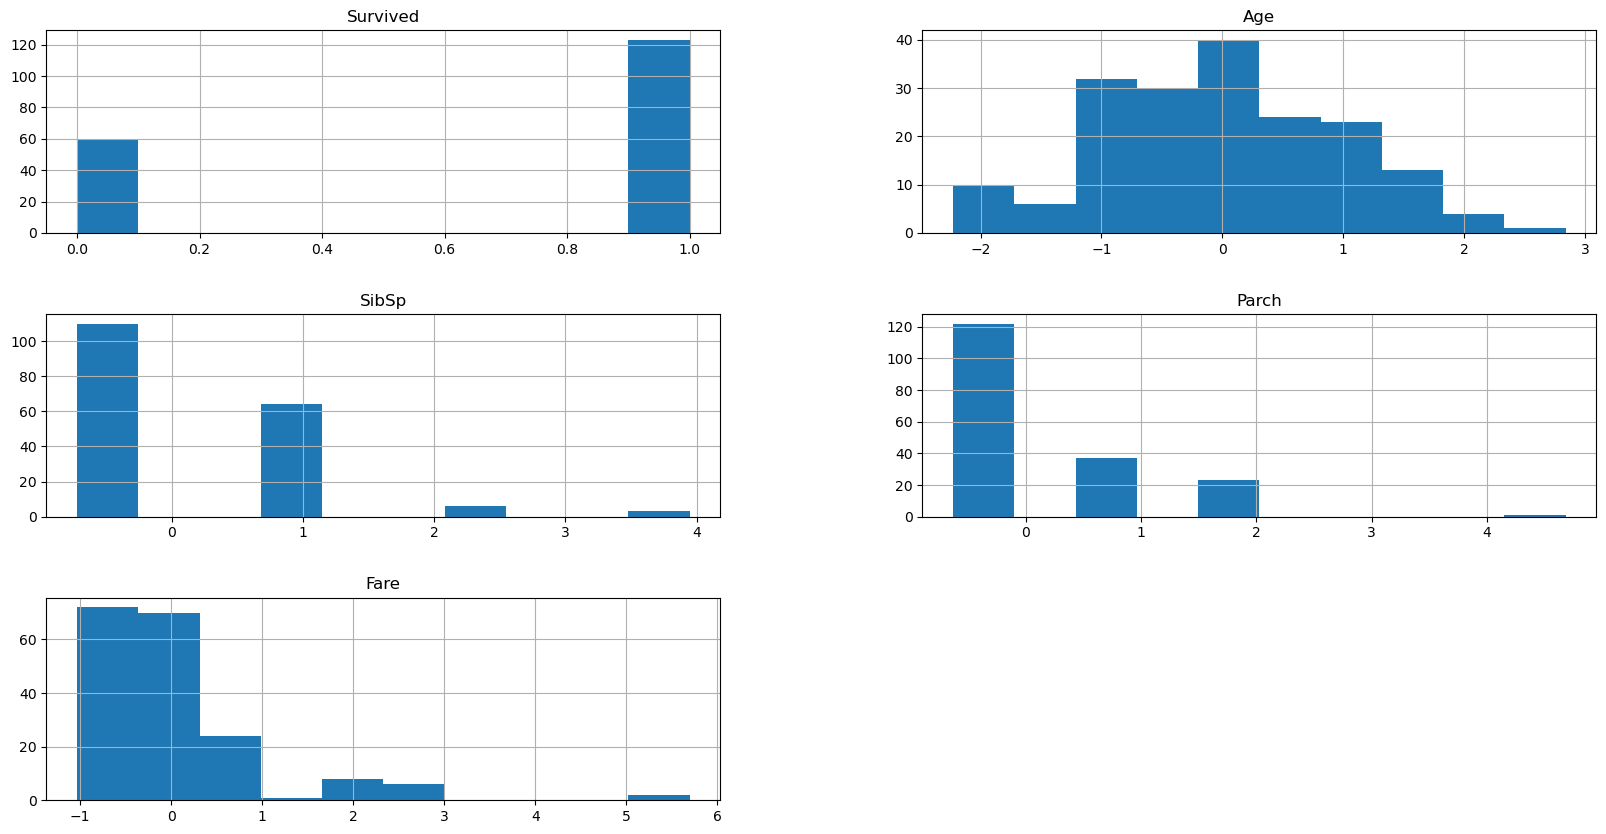

In [560]:
## histograms
data_stan.hist(figsize = (20, 10))
plt.margins(2,2)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

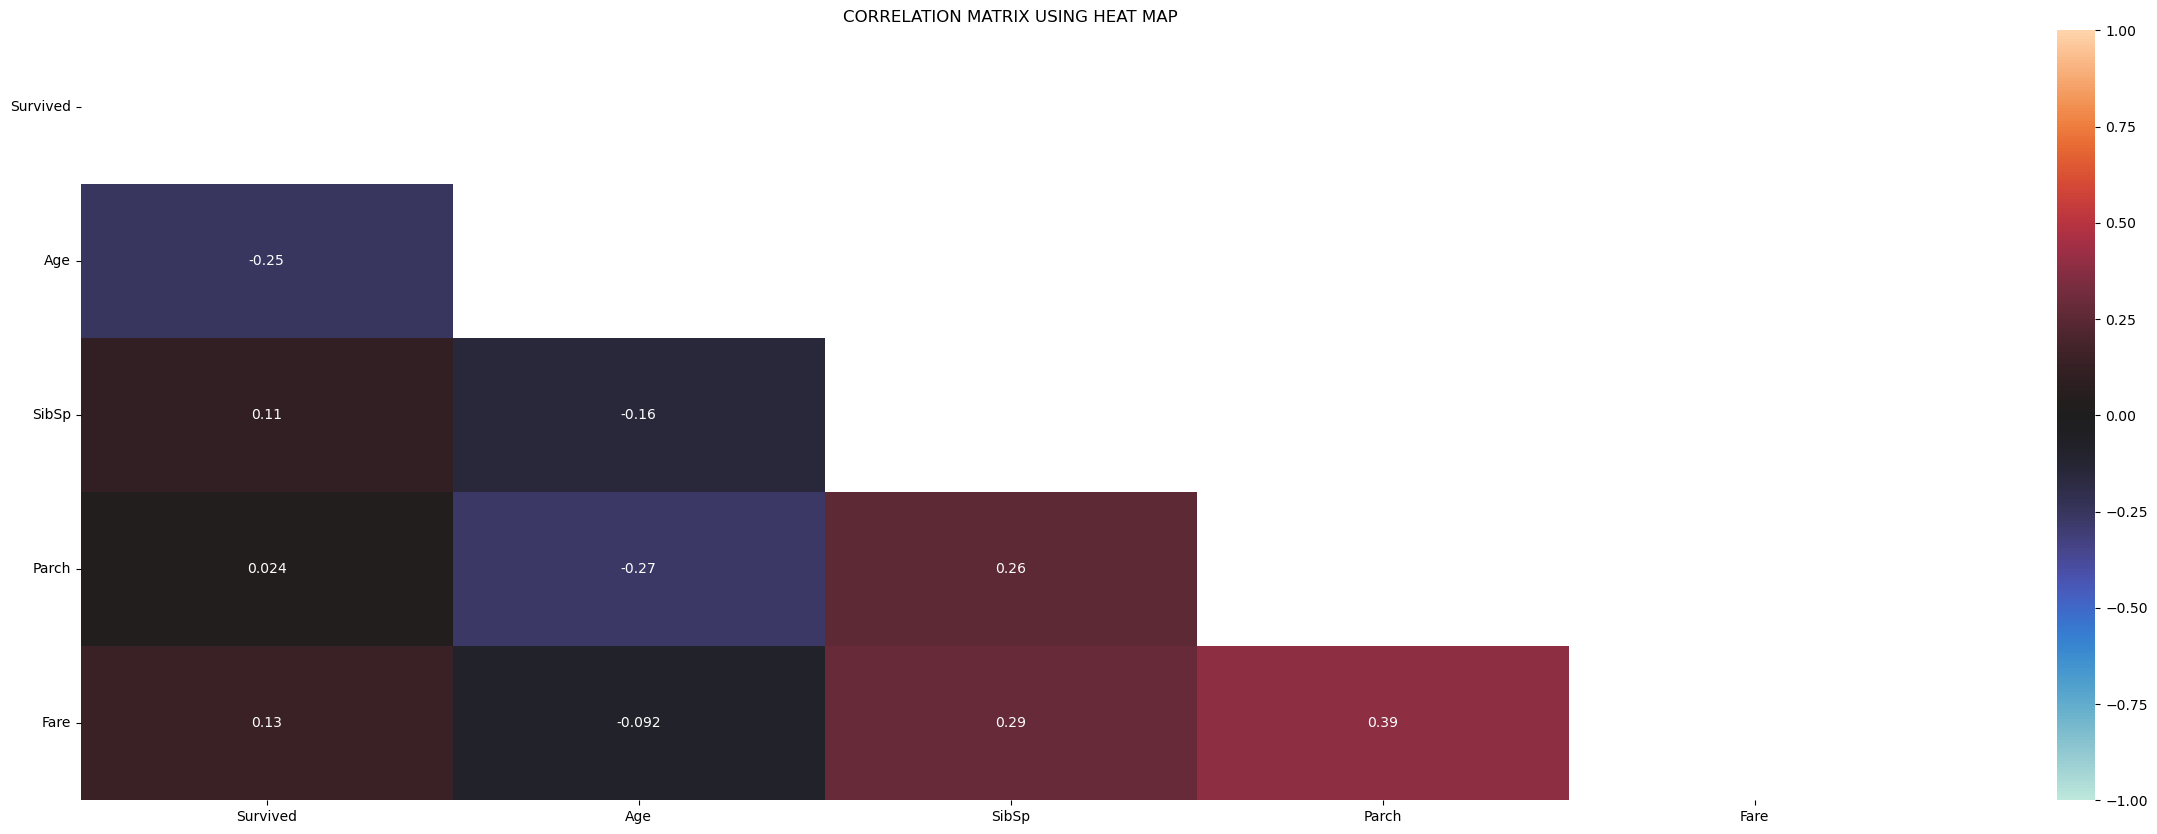

In [561]:
## correlation heatmap   
import seaborn as sns
import numpy as np

plt.figure(figsize=(30,10))
corMat = data_stan.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

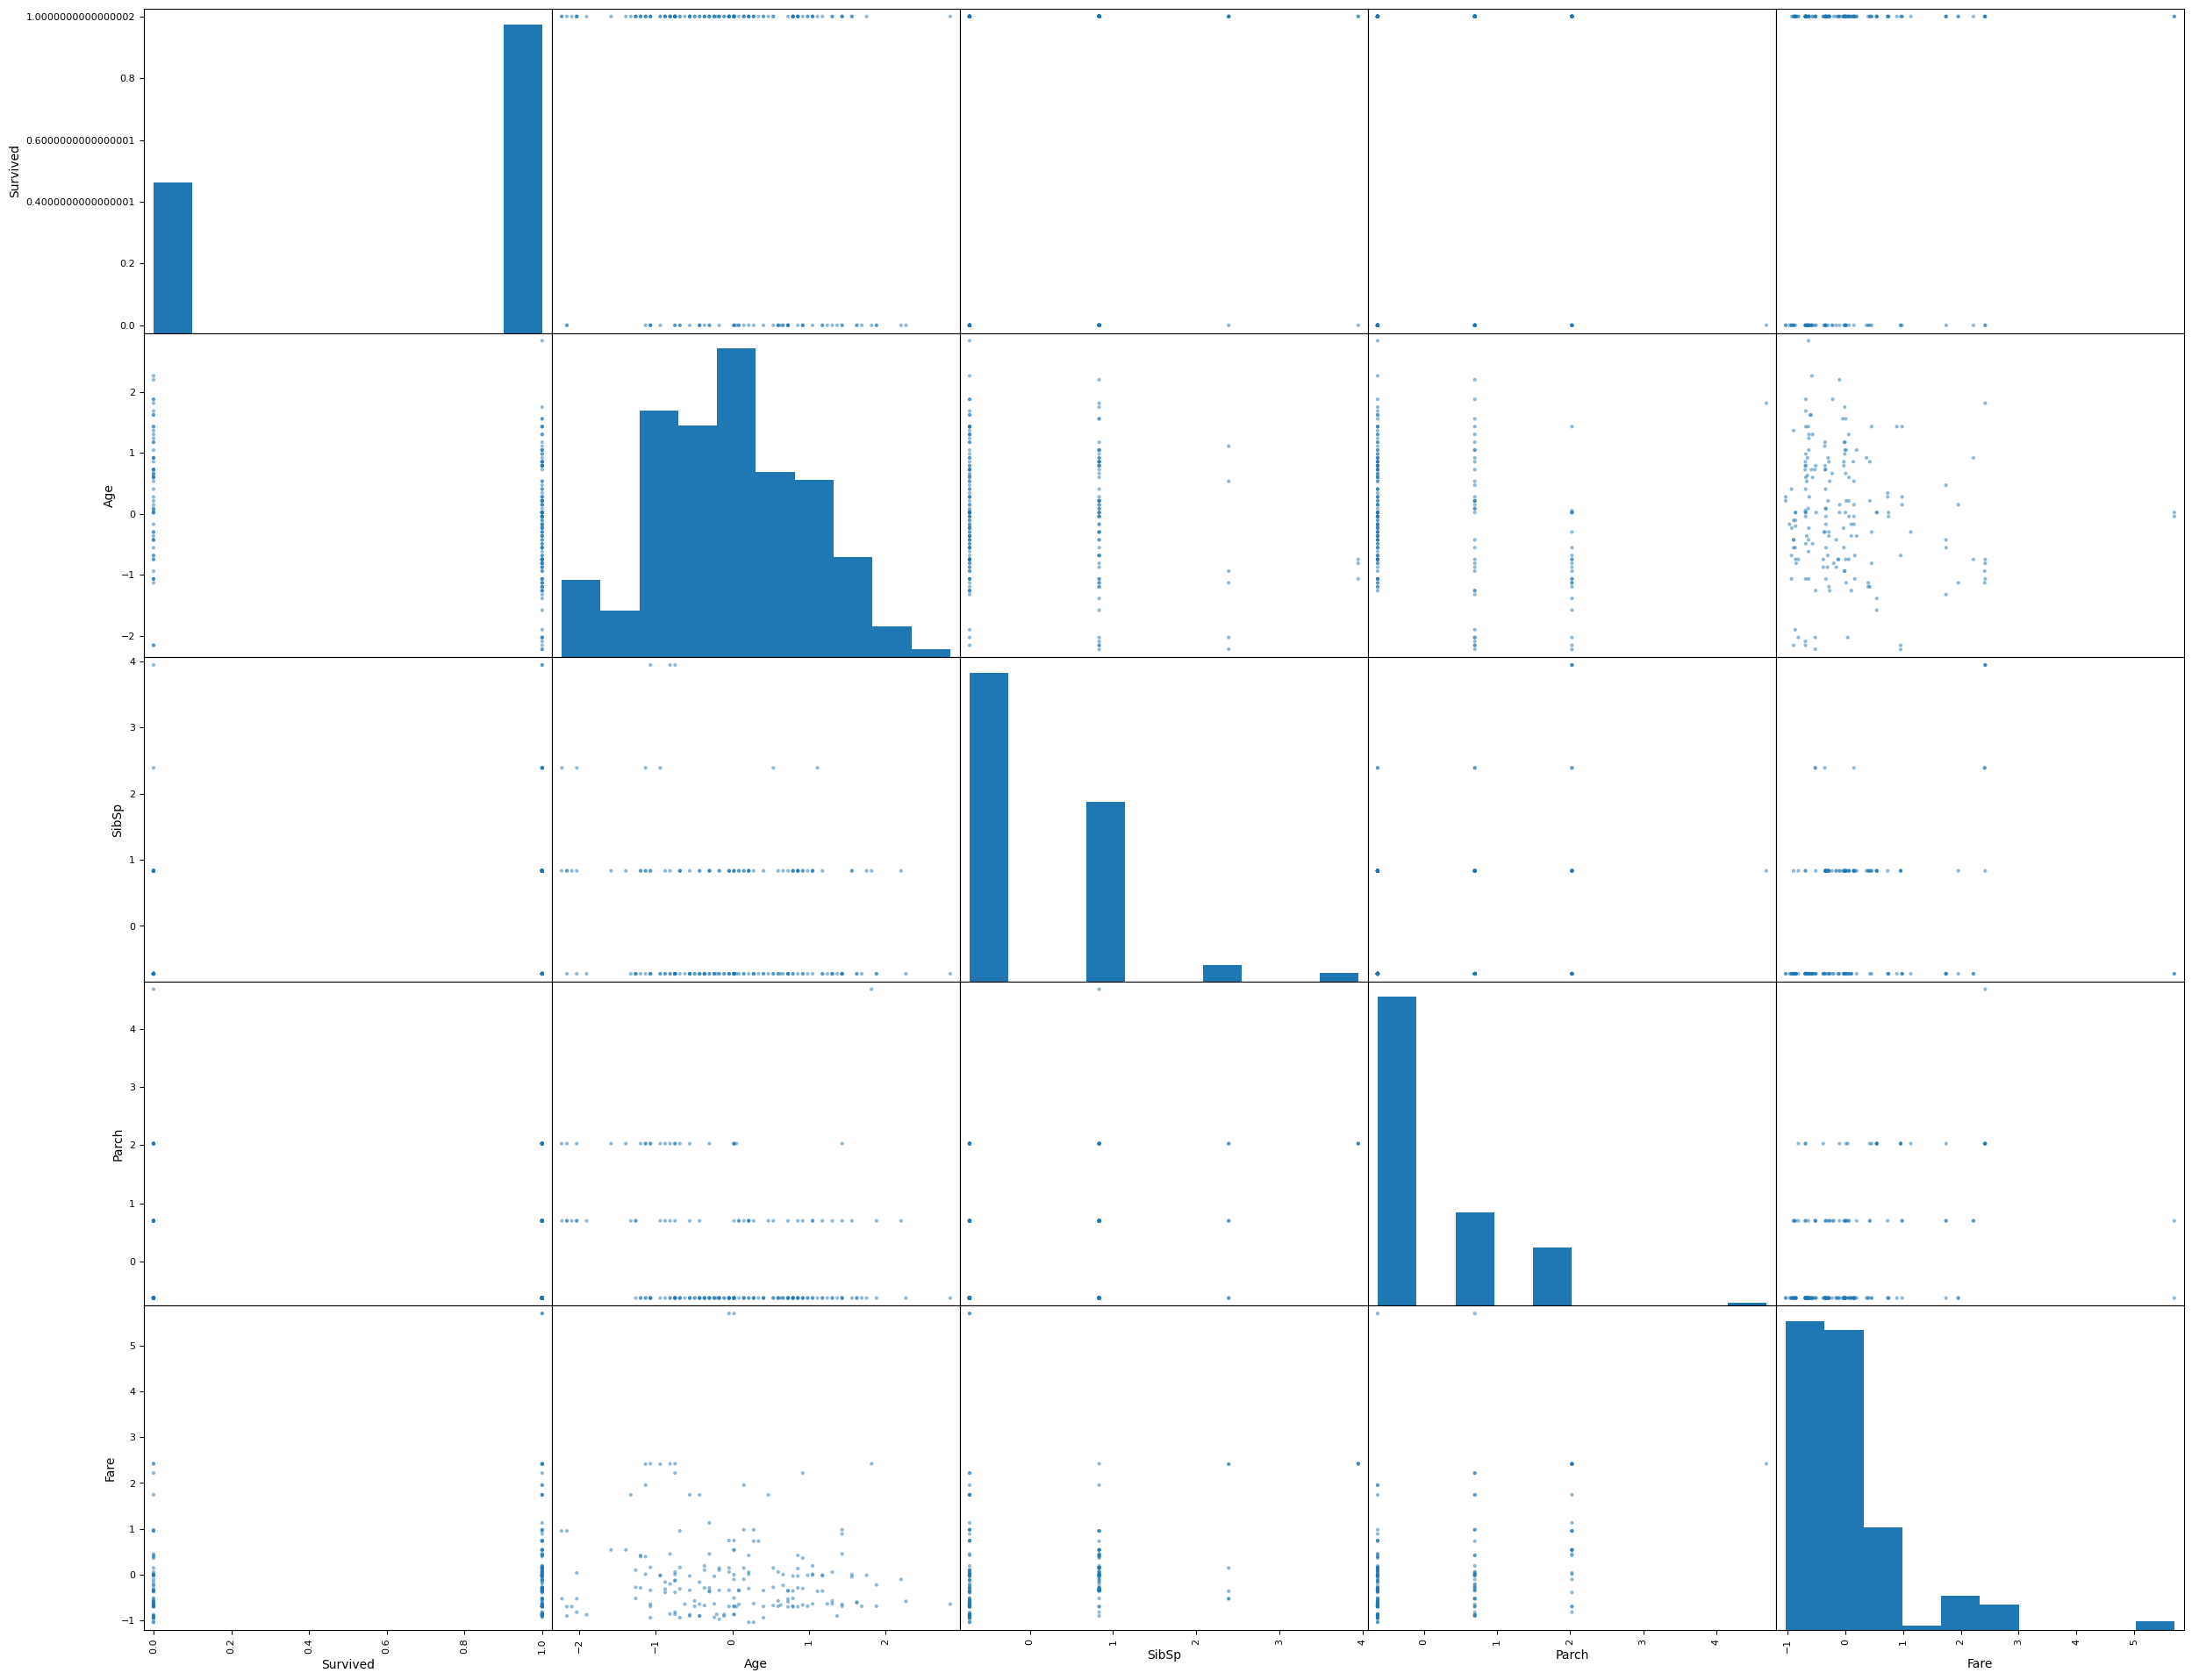

In [562]:
## scatterplots
from pandas.plotting import scatter_matrix

scatter_matrix(data_stan, figsize = (30,24))
plt.show()

## Notes on Scatterplots
-todo

## EDA with Normalized Data

In [563]:
data_norm = pd.DataFrame(MinMaxScaler().fit_transform(x_clean), columns=x_clean_names)
x_norm = pd.concat([data_norm, x_category], axis=1)
x_norm

,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked,Pclass
0,0.47,0.33,0.00,1.39e-01,2,0,0,1
1,0.43,0.33,0.00,1.04e-01,2,0,2,1
2,0.67,0.00,0.00,1.01e-01,4,1,2,1
3,0.04,0.33,0.25,3.26e-02,6,0,2,3
4,0.72,0.00,0.00,5.18e-02,2,0,2,1
...,...,...,...,...,...,...,...,...
178,0.58,0.33,0.25,1.03e-01,3,0,2,1
179,0.41,0.00,0.00,9.76e-03,1,1,2,1
180,0.70,0.00,0.25,1.62e-01,2,0,0,1
181,0.23,0.00,0.00,5.86e-02,1,0,2,1


In [564]:
data_norm = pd.concat([y, data_norm], axis=1)
data_norm

,Survived,Age,SibSp,Parch,Fare
0,1,0.47,0.33,0.00,1.39e-01
1,1,0.43,0.33,0.00,1.04e-01
2,0,0.67,0.00,0.00,1.01e-01
3,1,0.04,0.33,0.25,3.26e-02
4,1,0.72,0.00,0.00,5.18e-02
...,...,...,...,...,...
178,1,0.58,0.33,0.25,1.03e-01
179,0,0.41,0.00,0.00,9.76e-03
180,1,0.70,0.00,0.25,1.62e-01
181,1,0.23,0.00,0.00,5.86e-02


In [565]:
## descriptive stats
set_option('display.width', 100)
set_option('display.precision', 2)
description = data_norm.describe()
description

,Survived,Age,SibSp,Parch,Fare
count,183.00,183.00,183.00,183.00,183.00
mean,0.67,0.44,0.15,0.12,0.15
std,0.47,0.20,0.21,0.19,0.15
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.29,0.00,0.00,0.06
50%,1.00,0.44,0.00,0.00,0.11
75%,1.00,0.59,0.33,0.25,0.18
max,1.00,1.00,1.00,1.00,1.00


## Notes on Descriptive Statistics
-todo

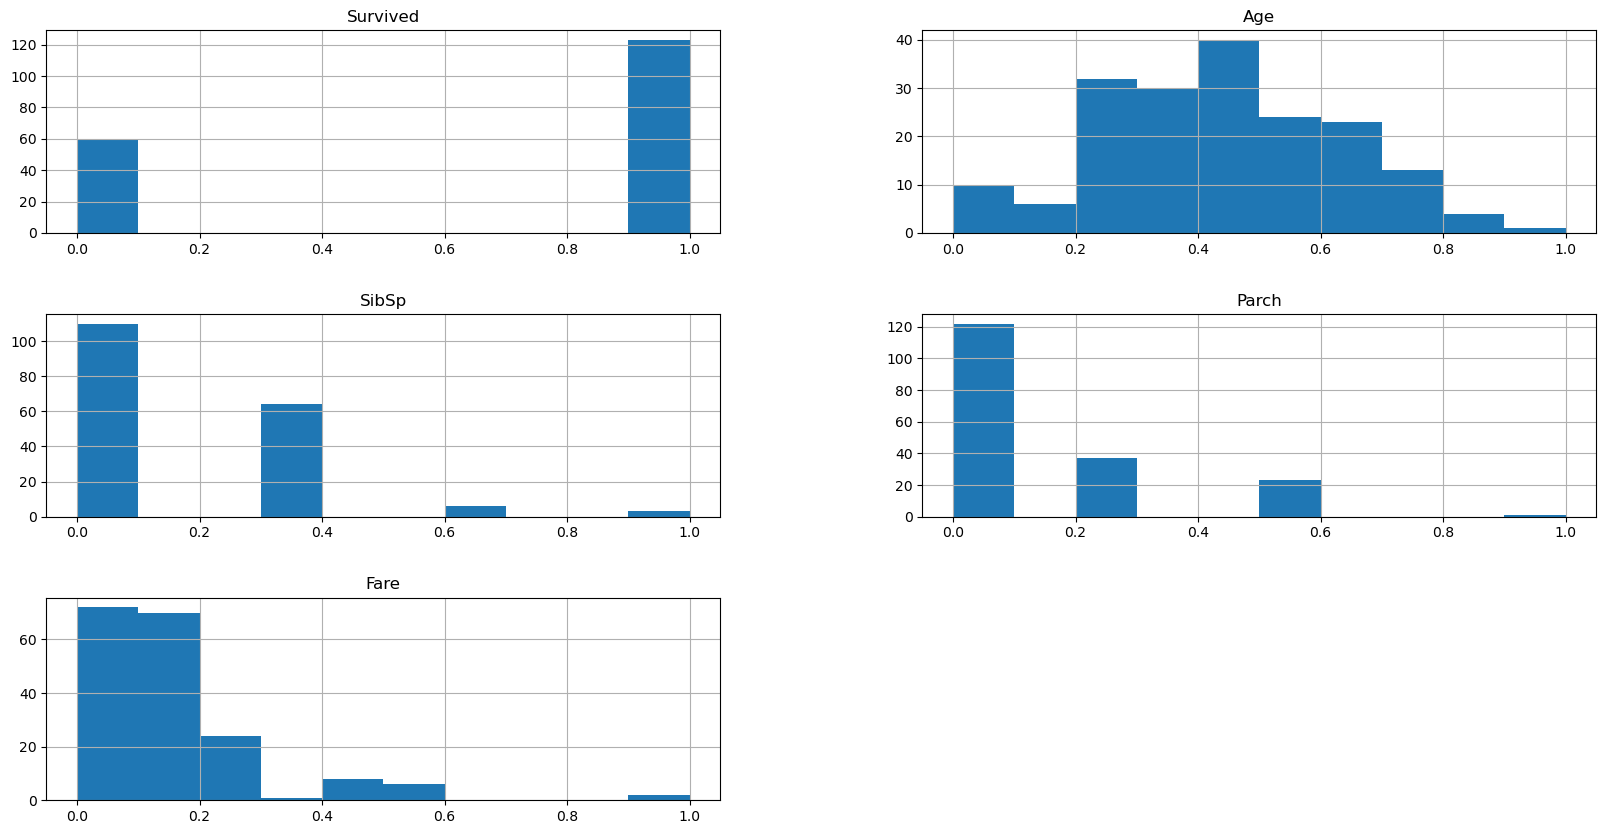

In [566]:
## histograms
data_norm.hist(figsize = (20, 10))
plt.margins(0,1)
plt.subplots_adjust(hspace = 0.4)
plt.show()

# Notes on Histograms
-todo

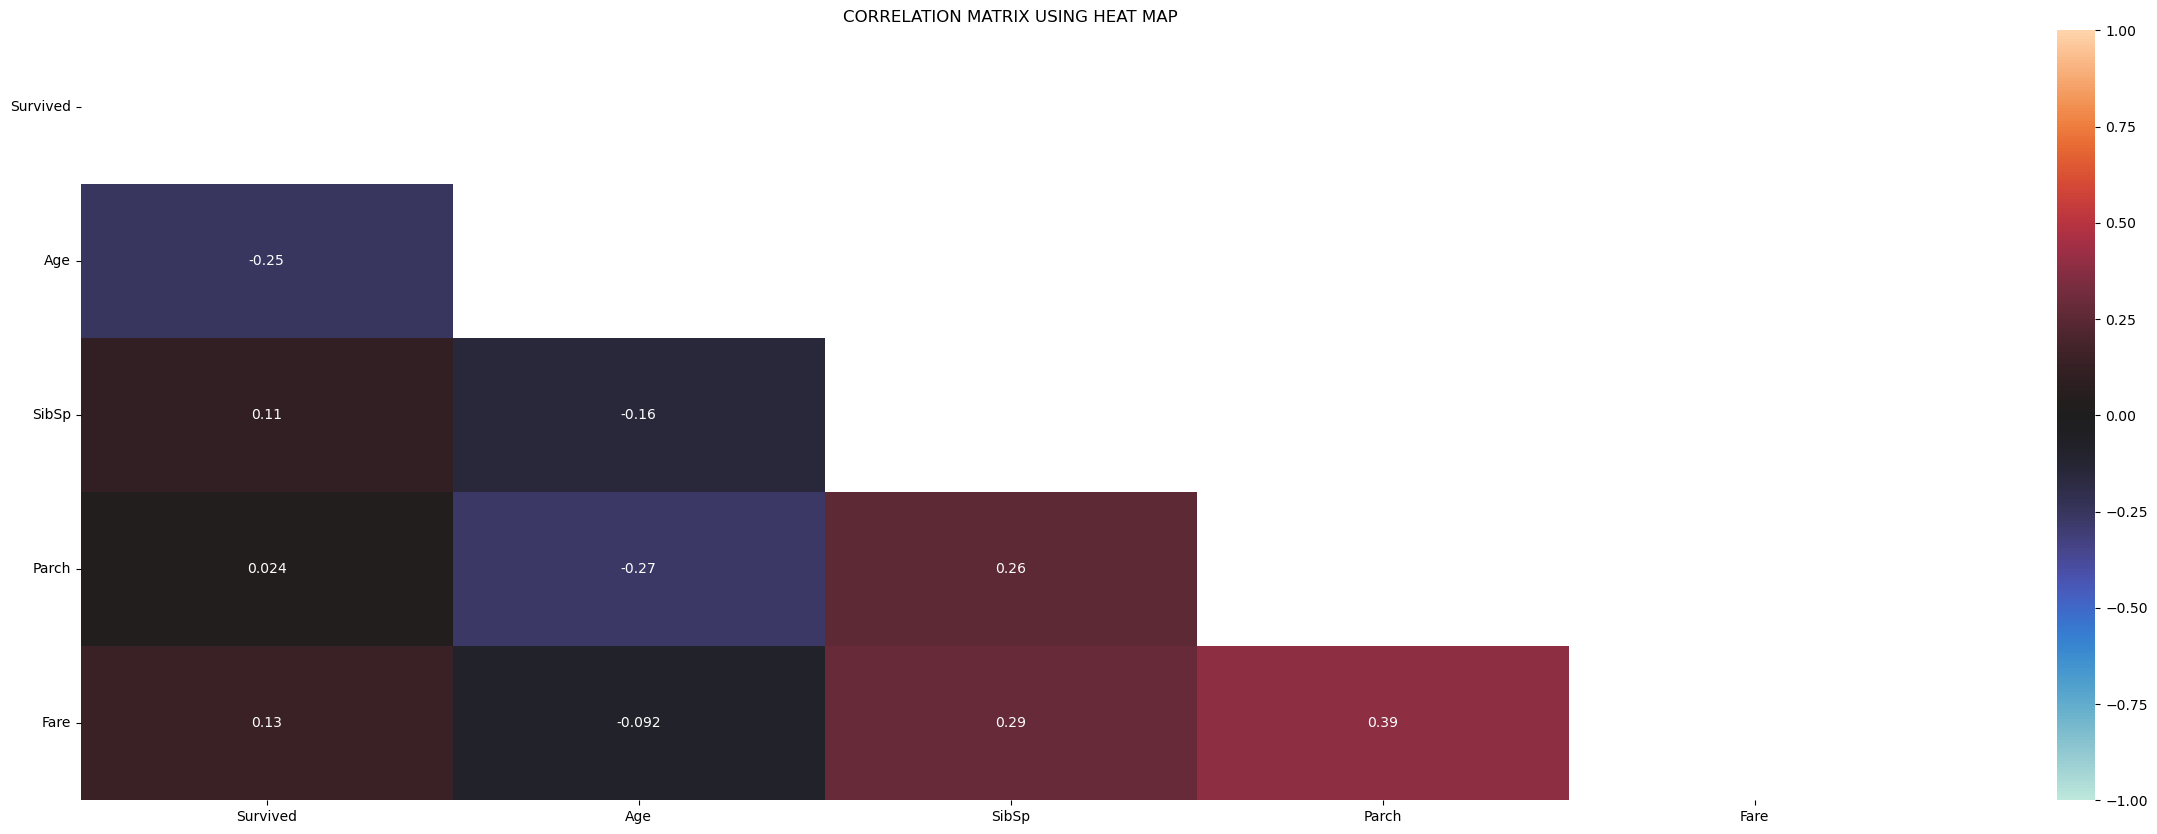

In [567]:
## correlation heatmap   
import seaborn as sns
import numpy as np

plt.figure(figsize=(30,10))
data_norm.corr(method="pearson")
mask_upper = np.triu(corMat)
sns.heatmap(corMat, annot=True, vmin = -1, vmax = 1, center = 0, mask = mask_upper)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("CORRELATION MATRIX USING HEAT MAP")
plt.show()

## Notes on Heatmap
-todo

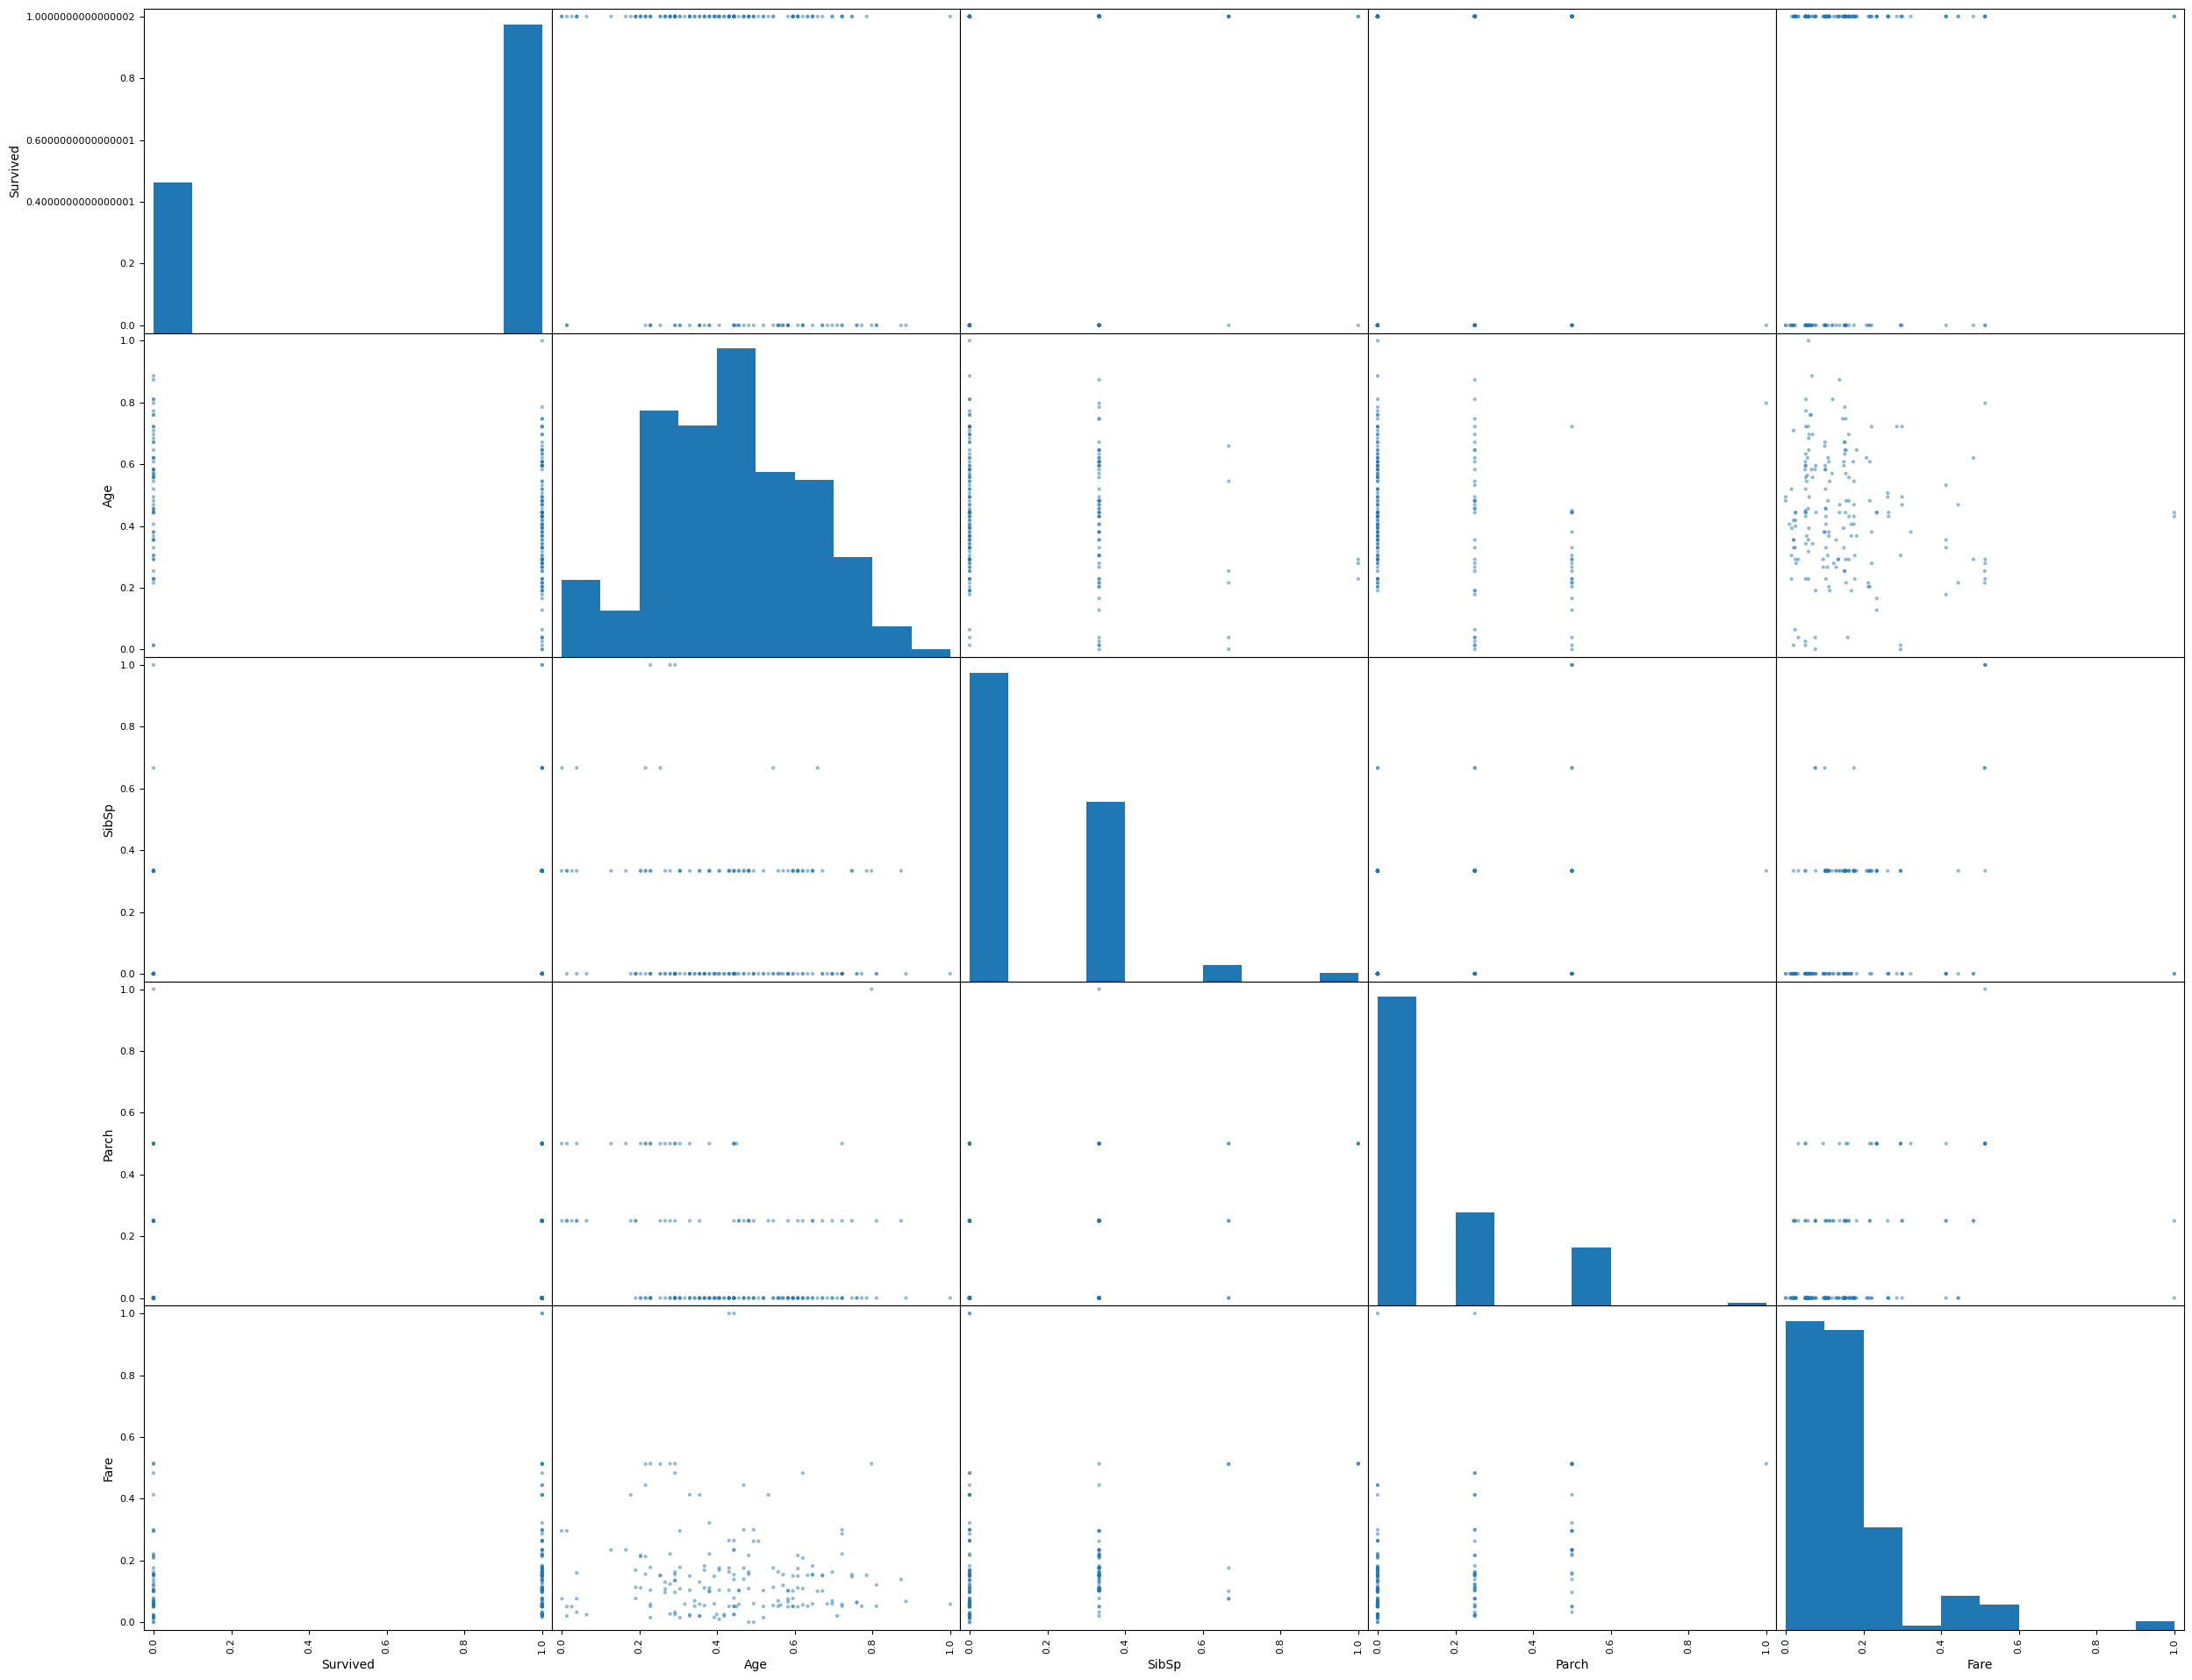

In [568]:
## scatterplots
from pandas.plotting import scatter_matrix

scatter_matrix(data_norm, figsize = (30,24))
plt.show()

## Notes on Scatterplots
-todo

## Model Fitting

In [569]:
# split train data for calculating accuracy

x_train, x_test, y_train, y_test = train_test_split(x_num, y, test_size=0.20, random_state=3)
x_train_stan, x_test_stan, y_train_stan, y_test_stan = train_test_split(x_stan, y, test_size=0.20, random_state=3)
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(x_norm, y, test_size=0.20, random_state=3)

### Logistic Regression

/Users/hmak/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


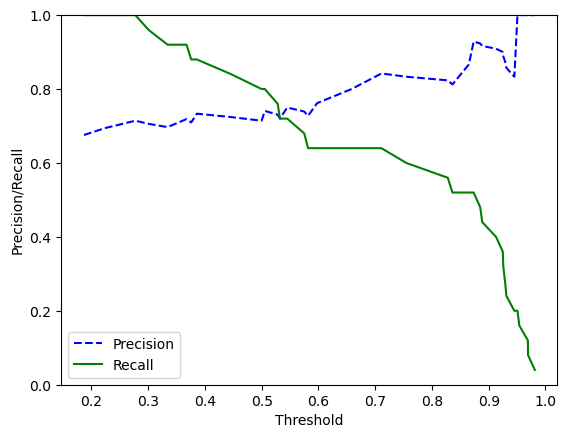

In [570]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve


model = LogisticRegression()
logit = model.fit(x_train,y_train)

y_scores =logit.predict_proba(x_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0, 1])
    plt.ylabel("Precision/Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

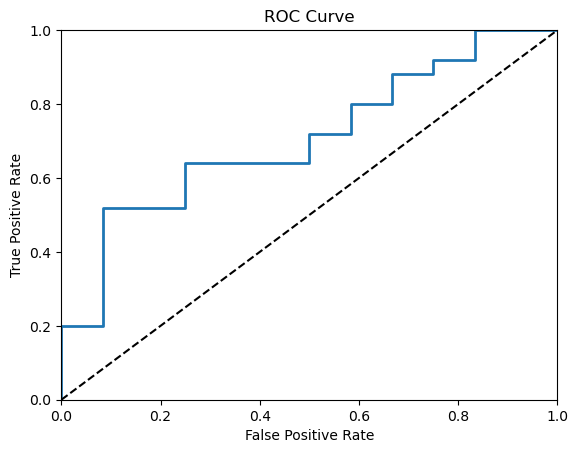

In [571]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds2 = roc_curve(y_test, y_scores[:,1])
# plot roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")

plt.figure()
plot_roc_curve(fpr, tpr)
plt.show()

### Random Forest Classifier (Ensemble)

### Bagging (Ensemble)

### ADA Boost

### K-means Clustering

### Decision Tree Classifier

In [572]:
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from io import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image


# decision tree with no max depth
dectree = DecisionTreeRegressor()
dectree.fit(x_train, y_train)

y_pred = dectree.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 0.2702702702702703
Mean Squared Error: 0.2702702702702703
Root Mean Squared Error: 0.5198752449100363


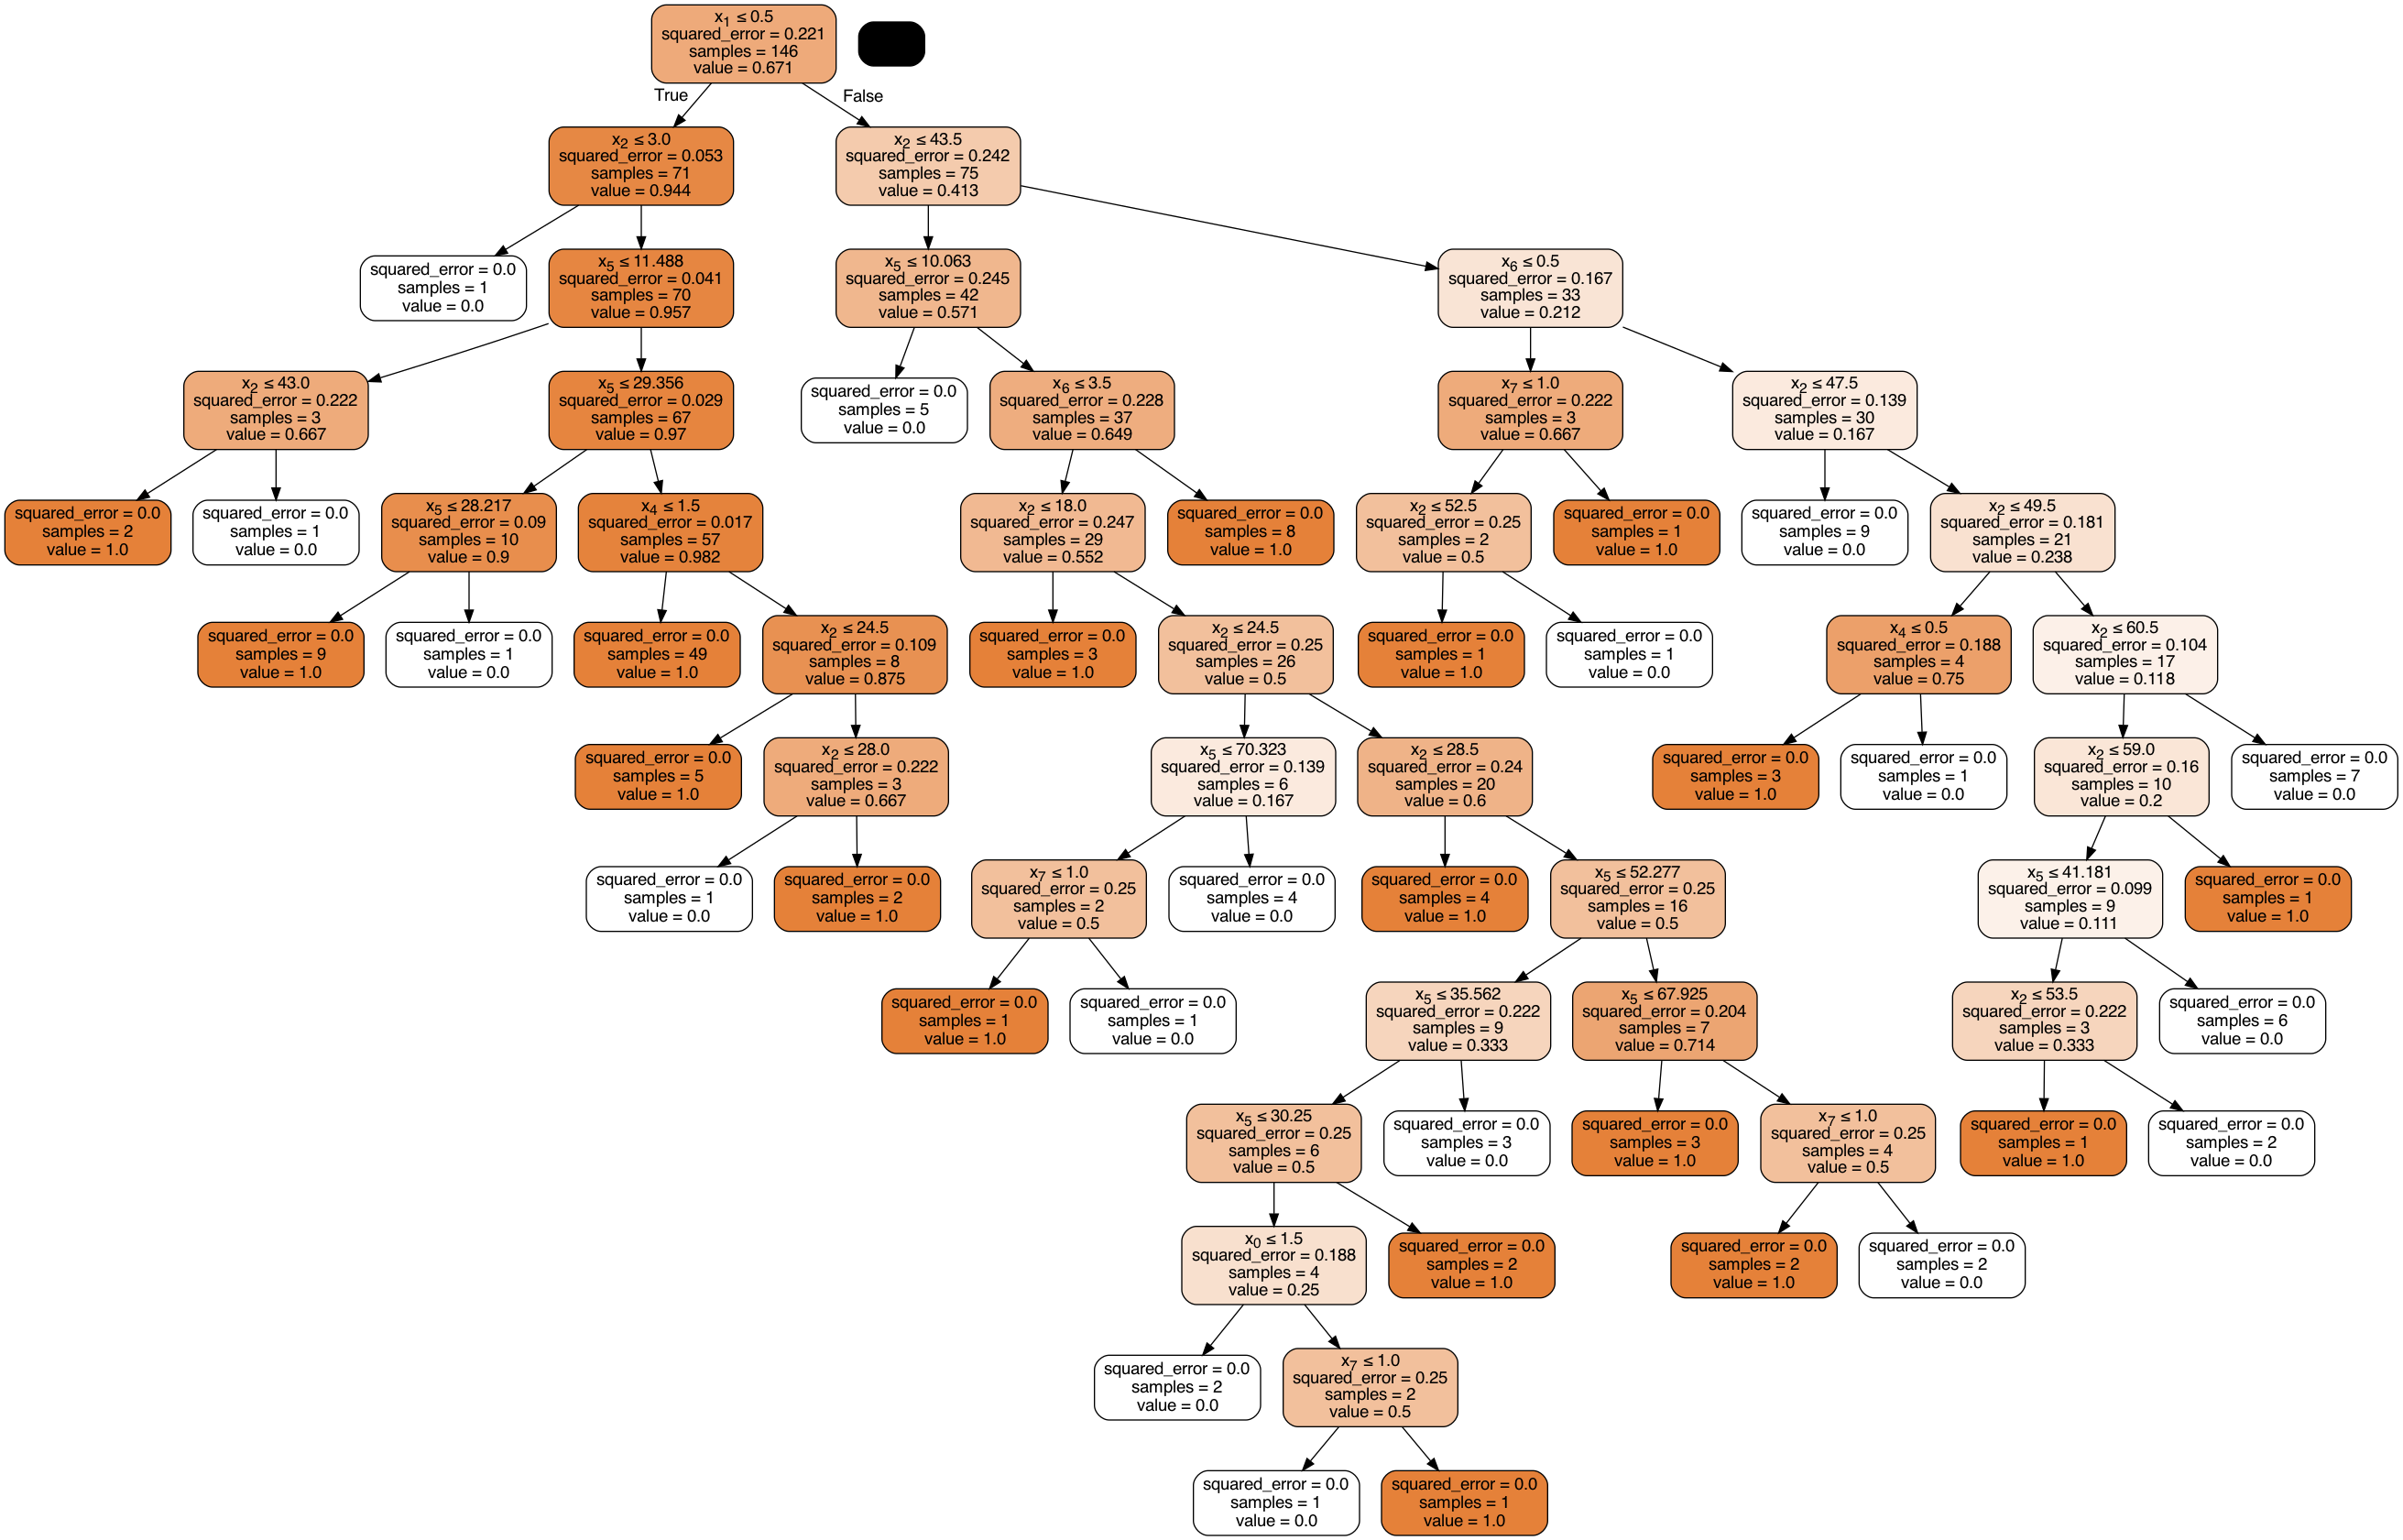

In [573]:
dot_data = StringIO()
export_graphviz(dectree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [574]:
# decision tree with max depth = 6
dectree_6 = DecisionTreeRegressor(max_depth=6)
dectree_6.fit(x_train, y_train)

y_pred = dectree_6.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))  

Mean Absolute Error: 0.3081081081081081
Mean Squared Error: 0.25837837837837835
Root Mean Squared Error: 0.5083093333575318


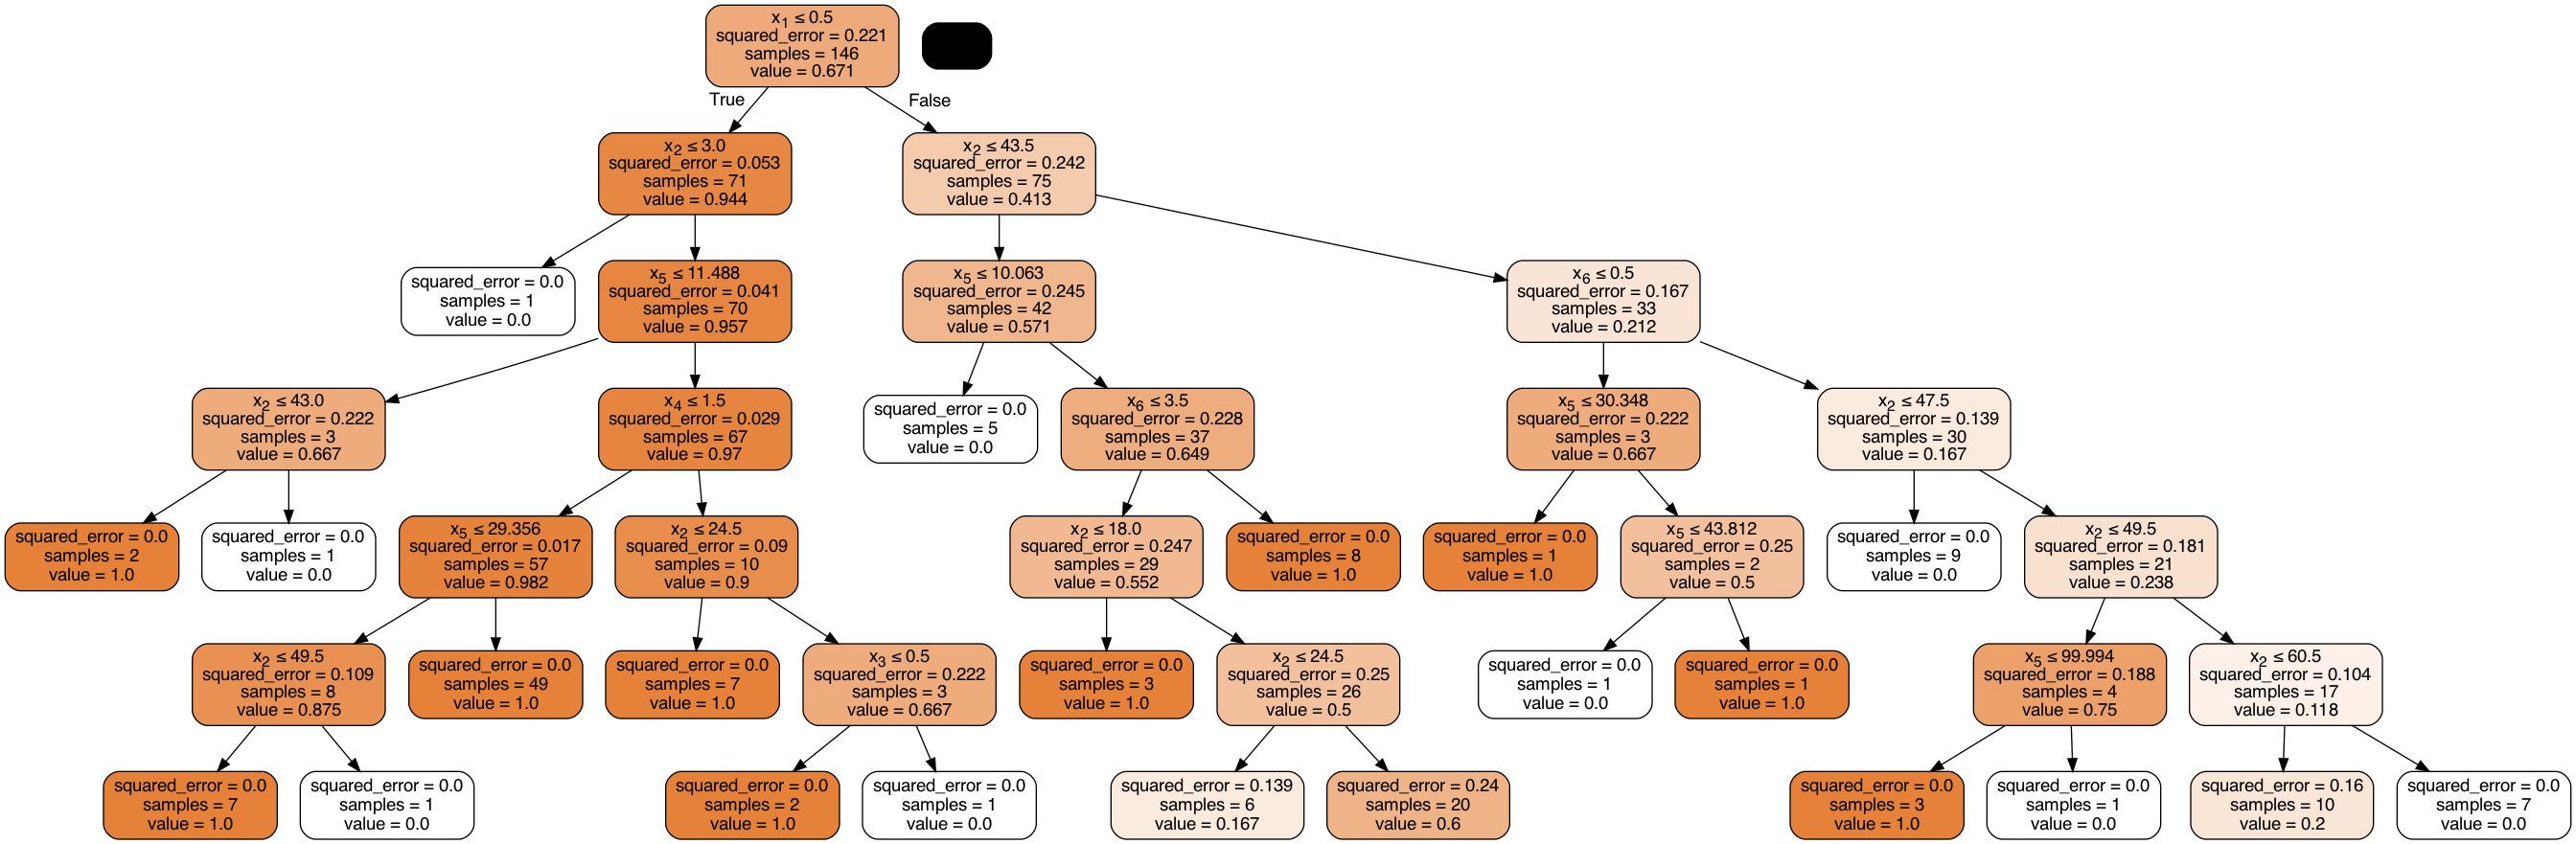

In [575]:
dot_data = StringIO()
export_graphviz(dectree_6, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Support Vector Model

### Neural Network

## Cross Validation with K-fold

## Conclusions
todo -after everything else

## References


## Appendix

https://github.com/aelichung/ml-titanic